In [5]:

import sys
import pathlib
import numpy as np
import pandas as pd
from rich.progress import track
from joblib import Parallel, delayed

import matplotlib.pyplot as plt
%matplotlib inline


import torch
from torch.utils.data import Dataset, DataLoader

sys.path.append("../src")
from utils.feature import FeatureStore
from utils.common import load_pickle, dump_pickle, save_cache

In [6]:
featfure_dir = pathlib.Path("../data/preprocessing/")

scaler = load_pickle(f"../data/scaler/scaler_wifi_rssi.pkl")
wifi_rssi = np.load(featfure_dir / "train_wifi_rssi.npy")

wifi_rssi = scaler.inverse_transform(wifi_rssi)
wifi_rssi = wifi_rssi.astype(int)

Load pickle from ../data/scaler/scaler_wifi_rssi.pkl


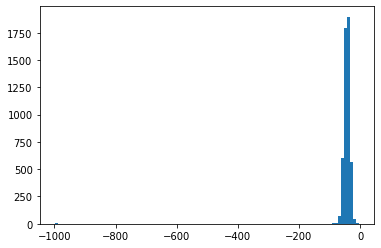

In [7]:
plt.figure()
plt.hist(wifi_rssi[:, 0], bins=100)
plt.show()

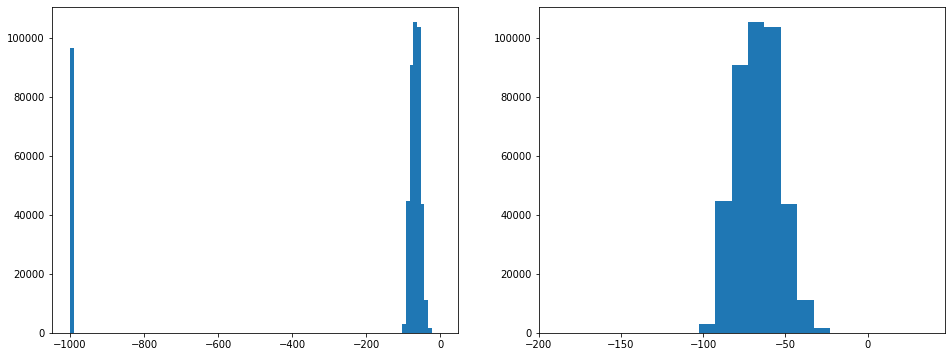

In [8]:
plt.figure(figsize=(16, 6))

plt.subplot(121)
plt.hist(wifi_rssi.ravel(), bins=100)

plt.subplot(122)
plt.hist(wifi_rssi.ravel(), bins=100)
plt.xlim(-200, None)

plt.show()